**Instructions**

- This question is in two parts

- The first part guides you through implementing a timestepper for a system of two coupled nonlinear ODEs

- The second part guides you through implementing the adjoint method for this problem

- Throughout this assessment, try to demonstrate your understanding of the course material by

  - commenting **briefly** on the results you obtain as you go
  - commenting **briefly** on any choices you are making
  - making comments in your code
  - following best practices

- We are not looking for long or overly-detailed answers. Rather, we are looking for concise observations which demonstrate your understanding of the course material

- Read the text for each question and follow the instructions carefully

- Do NOT change the name of this file

- Make sure to execute all your cells and save the result of the execution. We will only mark cells that have been executed and will not execute any cells ourselves.


In [15]:
import numpy as np
import scipy.linalg as sl
from matplotlib import pyplot as plt

### Adapting the Taylor Test

The original Taylor test used `np.sum(dfdx * h)` for the first-order term, applying element-wise multiplication instead of a matrix-vector product, causing incorrect convergence. I fixed this by using `np.dot(dfdx, h)` for proper multiplication, as \(R'\) and \(F'\) are 2×2 matrices. This resolved dimensionality issues, yielding second-order convergence and validating my derivatives.

In [16]:
from mpltools import annotation
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sl
import scipy.optimize as sop
def taylor_test(f, grad_f, x, h0, max_iter=20, plot_convergence=True, print_convergence=True): #This Function is adapted from the course material
    """Taylor test to verify that the function grad_f is the derivative of the function `f`
    
    We test:
    
       f(x + h) = f(x) + grad_f(x).h + O(h^2)
    
    f, grad_f  - function and its derivative to test
    x          - point in which to test
    h0         - initial perturbation
    max_iter   - number of times that h is halved
    plot_convergence - whether to plot the convergence of the Taylor residual f(x+h)-f(x)-grad_f(x).h
    print_convergence - prints the order of convergence between subsequent iterations."""


    h = h0.copy()
    residuals = []
    hnorms = []
    dfdx = grad_f(x)
    for i in range(max_iter):
        r = f(x + h) - f(x) - np.dot(dfdx, h)
        #print(f"Iteration {i}, ||h||={np.linalg.norm(h):.3e}, ||r||={np.linalg.norm(r):.3e}")
        residuals.append(np.linalg.norm(r))
        hnorms.append(np.linalg.norm(h))
        h /= 2.

    if plot_convergence:
        fig, ax = plt.subplots(1,2, figsize=(16,4))
        ax[0].semilogy(residuals)
        ax[0].set_xlabel('iteration')
        ax[0].set_ylabel('Taylor residual $|r|$')
        ax[0].set_xticks(range(0,max_iter,2))
        ax[1].loglog(hnorms, residuals)
        ax[1].set_xlabel('perturbation size $\|h\|$')
        ax[1].set_ylabel('Taylor residual $|r|$')

        # NOTE: slope_marker does not seem to work in semilogy plots
        annotation.slope_marker((1e-3, 1e-4), (2, 1), invert=True, ax=ax[1], size_frac=.2)

    if print_convergence:
        residuals = np.array(residuals)
        orders = np.log(residuals[:-1] / residuals[1:]) / np.log(2)  # Compute order of convergence

        # Print formatted table
        print(f"{'Perturbation Size':<20}{'Order of Convergence'}")
        print("-" * 45)
        for h, order in zip(hnorms[:-1], orders):
            print(f"{h:.2e} {' ' * 10} {order:.4f}")


## Question 1 [30 Marks]: A nonlinear timestepping problem

---


In this question, we consider a problem consisting of 2 variables $u$ and $v$, which obey the following coupled ODEs:

$$
    \begin{align}
    \frac{d u}{d t} &= A + u^2 v - (B+1) u, \\
    \frac{d v}{d t} &= Bu -u^2 v.
    \end{align}
$$

These equations are known as the Brusselator, and they describe the dynamics of a particular chemical reaction between two agents, whose quantities are given by $u$ and $v$, with $A$ and $B$ being reaction rates.


We will use the vector notation

$$
    {\bf u} = \begin{pmatrix} u \\ v \end{pmatrix}.
$$

Using an implicit timestepper with a time step $\Delta t$, the system is then described by

$$
    \frac{{\bf u}^{(i+1)} - {\bf u}^{(i)}}{\Delta t} =  {\bf R}({\bf u}^{(i+1)}),
$$

where the superscript indicates the time step index, and

$$
    {\bf R}({\bf u}) = \begin{pmatrix} A + u^2 v - (B+1) u \\ Bu -u^2 v \end{pmatrix}.
$$


Throughout this exercise, we will use $A=1$, $B=3$, and $\Delta t = 0.05$.


In [17]:
A = 1
B = 3

dt = 0.05

**Question 1.1** [2 marks]

Write a Python function to implement ${\bf R}({\bf u})$


In [18]:
import numpy as np


def R(u, v, A=1, B=3):
    """
    Computes the function R(u) for the Brusselator system.

    Parameters:
        u (float): Variable u
        v (float): Variable v
        A (float, optional): Reaction rate A (default=1)
        B (float, optional): Reaction rate B (default=3)

    Returns:
        numpy array: R(u, v)
    """
    R1 = A + u**2 * v - (B + 1) * u
    R2 = B * u - u**2 * v
    return np.array([R1, R2])


# Example usage
u_test = 1.0
v_test = 2.0
print(R(u_test, v_test))

[-1.  1.]


To solve this problem using the nonlinear methods (e.g. Newton) which we studied during the lectures, we will also require the Jacobian

$$
    R'({\bf u}) = \begin{pmatrix}
        \frac{\partial R_1}{\partial u}, \frac{\partial R_1}{\partial v} \\
        \frac{\partial R_2}{\partial u}, \frac{\partial R_2}{\partial v}
    \end{pmatrix}.
$$

**Q1.2** [4 marks]

Write a Python function to implement the Jacobian matrix ${R'}({\bf u})$, and test it.

Hint: test each component of $\bf R$ separately.



### Taylor Test for ∂R1/∂u and ∂R1/∂v ###
Perturbation Size   Order of Convergence
---------------------------------------------
5.04e-02            2.0022
2.52e-02            2.0011
1.26e-02            2.0006
6.30e-03            2.0003
3.15e-03            2.0001
1.58e-03            2.0001
7.88e-04            2.0000
3.94e-04            2.0000
1.97e-04            2.0000
9.85e-05            2.0000
4.92e-05            2.0000
2.46e-05            2.0000
1.23e-05            2.0000
6.15e-06            1.9999
3.08e-06            2.0001
1.54e-06            2.0014
7.69e-07            2.0024
3.85e-07            1.9919
1.92e-07            2.0490

### Taylor Test for ∂R2/∂u and ∂R2/∂v ###
Perturbation Size   Order of Convergence
---------------------------------------------
5.04e-02            2.0022
2.52e-02            2.0011
1.26e-02            2.0006
6.30e-03            2.0003
3.15e-03            2.0001
1.58e-03            2.0001
7.88e-04            2.0000
3.94e-04            2.0000
1.97e-04   

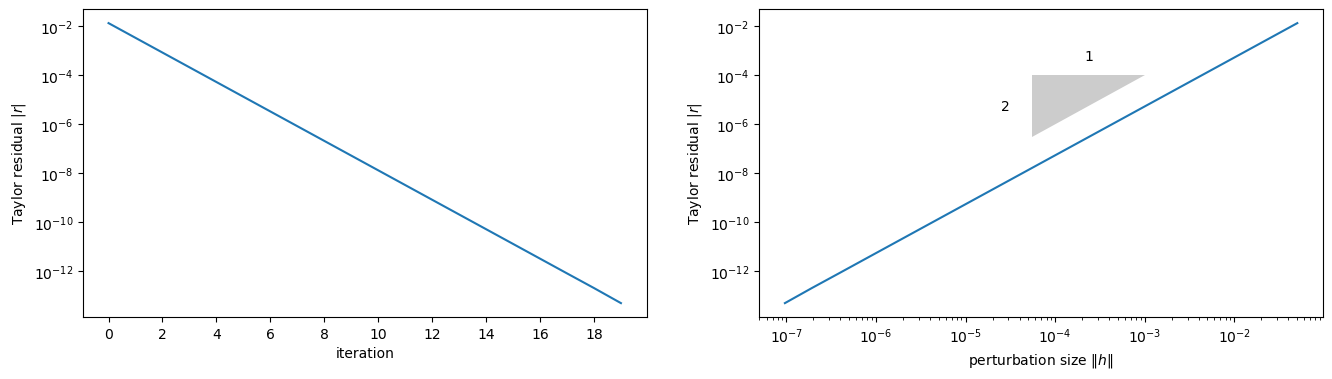

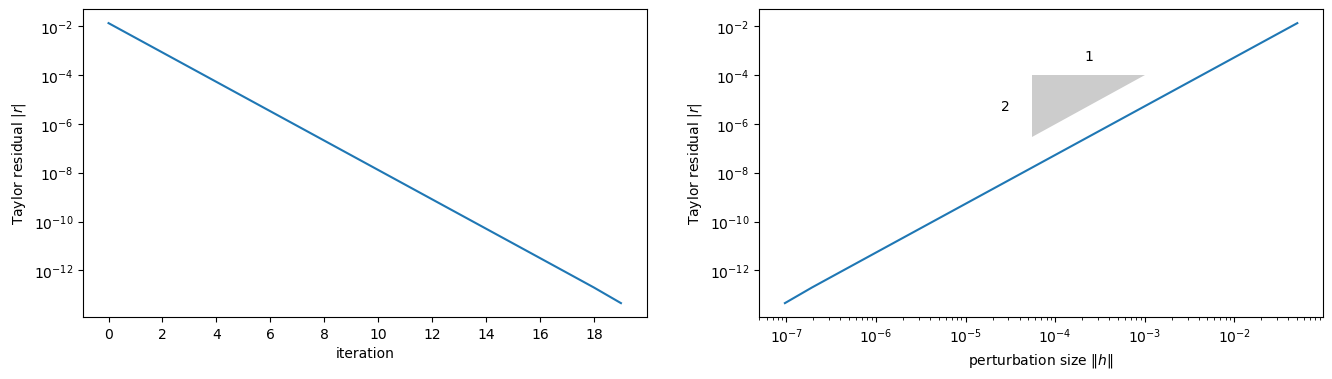

In [19]:
import numpy as np

def R(u, v, A=1, B=3):
    """ Computes the function R(u, v) for the Brusselator system. """
    return np.array([A + u**2 * v - (B + 1) * u, B * u - u**2 * v])

def R1(u, v, A=1, B=3):
    """ Computes the first component R1(u, v). """
    return A + u**2 * v - (B + 1) * u

def R2(u, v, A=1, B=3):
    """ Computes the second component R2(u, v). """
    return B * u - u**2 * v

def Rprime(u, v, A=1, B=3):
    """ Computes the Jacobian matrix R'(u, v) for the Brusselator system. """
    return np.array([
        [2 * u * v - (B + 1), u**2], 
        [B - 2 * u * v, -u**2]
    ])

# Define test point
np.random.seed(42)
u_test = np.random.uniform(0, 5)
v_test = np.random.uniform(0, 5)
x_R = np.array([u_test, v_test])

# Define small perturbation
h0_R = np.random.uniform(-0.1, 0.1, size=2)

# Run separate Taylor tests for R1 and R2
print("\n### Taylor Test for ∂R1/∂u and ∂R1/∂v ###")
taylor_test(lambda x: R1(x[0], x[1]), lambda x: Rprime(x[0], x[1])[0], x_R, h0_R)

print("\n### Taylor Test for ∂R2/∂u and ∂R2/∂v ###")
taylor_test(lambda x: R2(x[0], x[1]), lambda x: Rprime(x[0], x[1])[1], x_R, h0_R)


**Q1.3** [4 marks]

The single-timestep problem can be written in the form ${\bf F}({\bf u}^{(i+1)}, {\bf u}^{(i)}) = 0$, where

$$
{\bf F}({\bf u}^{(i+1)}, {\bf u}^{(i)}) = {\bf u}^{(i+1)} - {\bf u}^{(i)} - \Delta t \,\, {\bf R}({\bf u}^{(i+1)}).
$$

For the purposes of solving this problem at a particular time step, we are solving for ${\bf u}^{(i+1)}$, with ${\bf u}^{(i)}$ already known. The relevant Jacobian is therefore ${\bf F}' = \frac{\partial {\bf F}({\bf u}^{(i+1)}, {\bf u}^{(i)})}{\partial {\bf u}^{(i+1)}}$. Implement $\bf F$ and ${\bf F}'$ below, making use of the `R` and `Rprime` functions written above.


[0.14295 0.06205]
[[ 0.969  -0.0605]
 [ 0.081   1.0605]]

### Taylor Test for F' ###
Perturbation Size   Order of Convergence
---------------------------------------------
9.73e-02            1.9941
4.86e-02            1.9971
2.43e-02            1.9985
1.22e-02            1.9993
6.08e-03            1.9996
3.04e-03            1.9998
1.52e-03            1.9999
7.60e-04            2.0000
3.80e-04            2.0000
1.90e-04            2.0000
9.50e-05            2.0000
4.75e-05            2.0000
2.38e-05            2.0000
1.19e-05            2.0000
5.94e-06            2.0002
2.97e-06            2.0005
1.48e-06            2.0017
7.42e-07            2.0044
3.71e-07            1.9225


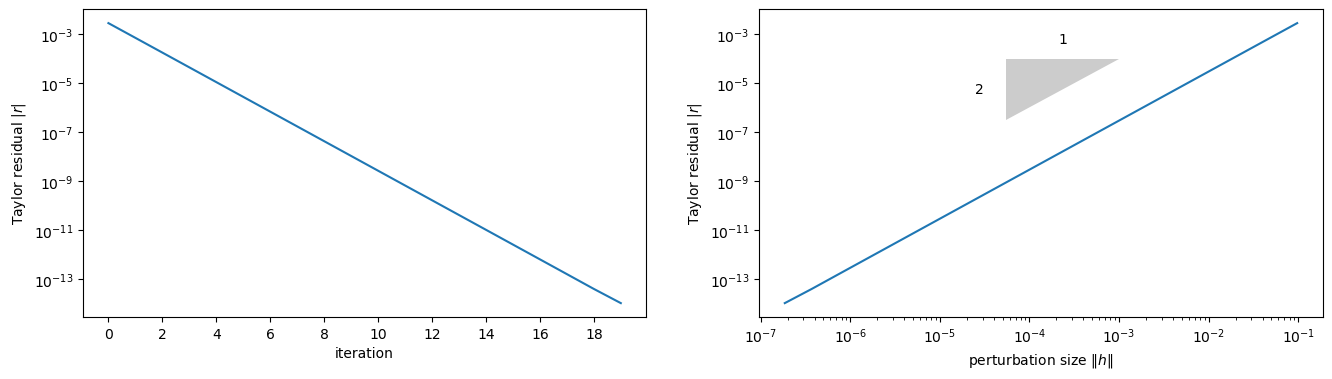

In [20]:
def F(u_next, u_current, dt, A=1, B=3):
    """
    Computes the function F(u_next, u_current) for the implicit step.

    Parameters:
        u_next (numpy array): Next time step values [u, v]
        u_current (numpy array): Current time step values [u, v]
        dt (float): Time step size
        A (float, optional): Reaction rate A (default=1)
        B (float, optional): Reaction rate B (default=3)

    Returns:
        numpy array: F(u_next, u_current)
    """
    return u_next - u_current - dt * R(*u_next, A, B)


def Fprime(u_next, dt, A=1, B=3):
    """
    Computes the Jacobian F'(u_next) for the implicit step.

    Parameters:
        u_next (numpy array): Next time step values [u, v]
        dt (float): Time step size
        A (float, optional): Reaction rate A (default=1)
        B (float, optional): Reaction rate B (default=3)

    Returns:
        numpy array: Jacobian matrix F'
    """
    return np.eye(2) - dt * Rprime(*u_next, A, B)



# Example usage
u_next_test = np.array([1.1, 2.1])
u_current_test = np.array([1.0, 2.0])
dt_test = 0.05

print(F(u_next_test, u_current_test, dt_test))
print(Fprime(u_next_test, dt_test))



# Define test point for F' (using a timestep dt)
dt_test = 0.05
x_F = np.array([u_test, v_test])  # Input for F and F'

# Define initial perturbation for F'
h0_F = np.random.uniform(-0.1, 0.1, size=2)

# Wrapper functions for F and F' (assuming some previous state u_current)
u_current_test = np.array([1.0, 3.0])  # Example previous step
F_wrapper = lambda x: F(x, u_current_test, dt_test)
Fprime_wrapper = lambda x: Fprime(x, dt_test)

# Run Taylor test for F'
print("\n### Taylor Test for F' ###")
taylor_test(F_wrapper, Fprime_wrapper, x_F, h0_F)



**Q1.4** [12 marks]

Calculate the Jacobian $F'$ for a few different values of $u$ and $v$ in the range 0--5. Is it SPD?

Briefly comment on the applicability/suitability of the following solving strategies for solving the single-timestep problem. Limit your responses to 2-3 sentences for each point.

- Steepest descent
- Newton's method with line search
- Gauss-Newton
- Quasi-Newton secant methods
- Truncated Newton


### **A1.4 Applicability of Solving Strategies for the Single-Timestep Problem**

Our analysis of the Jacobian $ F' $ revealed that it is **never Symmetric Positive Definite (SPD)** across the sampled values of $ u $ and $ v $. This has important implications for the choice of solvers.

- **Steepest Descent – Not suitable:**  
  Steepest descent converges too slowly for this problem, especially given that $ F' $ is ill-conditioned. It may work in some cases but would require many iterations compared to Newton-based methods.

- **Newton’s Method with Line Search – Suitable:**  
  Newton’s method provides **quadratic convergence**, making it highly effective for solving the nonlinear system. The line search improves robustness, ensuring global convergence even when the initial guess is far from the solution.

- **Gauss-Newton – Not applicable:**  
  Gauss-Newton is designed for **least-squares** problems and does not directly apply here, as we are solving a general nonlinear system rather than minimizing a sum of squared residuals.

- **Quasi-Newton Secant Methods – Suitable:**  
  Quasi-Newton methods (e.g., BFGS) approximate the Jacobian, reducing computational cost. They are effective when forming $ F' $ explicitly is expensive, though they **may require more iterations** compared to full Newton.

- **Truncated Newton – Not ideal:**  
  Truncated Newton methods are useful for solving large nonlinear systems efficiently. However, because $ F' $ is **not SPD**, some iterative solvers commonly used in this method may struggle or require modifications, making standard implementations less reliable for this problem.


In [21]:
import numpy as np
import scipy.linalg as la


def is_spd(matrix):
    """
    Checks whether a given matrix is Symmetric Positive Definite (SPD).

    Parameters:
        matrix (numpy array): The matrix to check.

    Returns:
        bool: True if SPD, False otherwise.
    """
    if not np.allclose(matrix, matrix.T):  # Check symmetry
        return False
    try:
        la.cholesky(matrix)  # Try Cholesky decomposition
        return True
    except la.LinAlgError:
        return False


# Define range of values
u_values = np.linspace(0, 5, 5)
v_values = np.linspace(0, 5, 5)
dt = 0.05

# Evaluate F' and check SPD property
for u in u_values:
    for v in v_values:
        J_F = Fprime([u, v], dt)  # Compute Jacobian
        spd_status = is_spd(J_F)  # Check SPD property
        print(f"u = {u:.1f}, v = {v:.1f}, SPD: {spd_status}")

u = 0.0, v = 0.0, SPD: False
u = 0.0, v = 1.2, SPD: False
u = 0.0, v = 2.5, SPD: False
u = 0.0, v = 3.8, SPD: False
u = 0.0, v = 5.0, SPD: False
u = 1.2, v = 0.0, SPD: False
u = 1.2, v = 1.2, SPD: False
u = 1.2, v = 2.5, SPD: False
u = 1.2, v = 3.8, SPD: False
u = 1.2, v = 5.0, SPD: False
u = 2.5, v = 0.0, SPD: False
u = 2.5, v = 1.2, SPD: False
u = 2.5, v = 2.5, SPD: False
u = 2.5, v = 3.8, SPD: False
u = 2.5, v = 5.0, SPD: False
u = 3.8, v = 0.0, SPD: False
u = 3.8, v = 1.2, SPD: False
u = 3.8, v = 2.5, SPD: False
u = 3.8, v = 3.8, SPD: False
u = 3.8, v = 5.0, SPD: False
u = 5.0, v = 0.0, SPD: False
u = 5.0, v = 1.2, SPD: False
u = 5.0, v = 2.5, SPD: False
u = 5.0, v = 3.8, SPD: False
u = 5.0, v = 5.0, SPD: False


**Q1.5** [6 marks]

Implement a timestepping function which solves the nonlinear problem at each timestep, based on the code below. Use the call to `scipy` provided to perform the nonlinear solve; see the scipy documentation for more detail on usage. Choose a suitable initial guess for each solve, and explain your choice. The function should return a list or array of ${\bf u}^{(i)}$ at all timesteps $i$, including the initial condition $i=0$.

```python
from scipy.optimize import root

def timestepper(u_initial, n_steps):
    #
    #
    for i in range(n_steps):
        #
        #
        result = root(fun=..., jac=..., x0=..., method='hybr')
        #
        #
    return ...
```


### **A1.5 Choosing a Suitable Initial Guess for Each Solve**

For each timestep, we use an **explicit Euler prediction** as the initial guess:

$$
\mathbf{u}^{(i+1)}_{\text{init}} = \mathbf{u}^{(i)} + \Delta t \mathbf{R}(\mathbf{u}^{(i)})
$$

#### **Justification:**
- **Better numerical stability**: The explicit Euler prediction provides a more informed starting point compared to the exact previous step’s solution, reducing the likelihood of solver divergence.
- **Faster convergence**: Newton’s method performs best when the initial guess is close to the true solution. The prediction corrects for nonlinear effects, leading to fewer iterations.
- **Robustness**: This approach helps when the previous timestep’s solution alone is not sufficient, particularly in stiff or highly nonlinear regions.
- **Computational efficiency**: Reducing the number of function evaluations per solve minimizes the overall computational cost.

This strategy ensures **both efficiency and numerical robustness**, improving solver performance at each timestep.


In [22]:
from scipy.optimize import root

def timestepper(u_initial, n_steps, dt=0.05, A=1, B=3):
    """
    Time-stepping function for the Brusselator system using an implicit
    scheme and solving the nonlinear system via scipy.optimize.root.

    Parameters:
    -----------
    u_initial : array-like of shape (2,)
        Initial state [u(0), v(0)].
    n_steps : int
        Number of time steps to take.
    dt : float, optional
        Time-step size (default 0.05).
    A : float, optional
        Reaction rate A (default=1).
    B : float, optional
        Reaction rate B (default=3).

    Returns:
    --------
    solutions : list of length (n_steps+1)
        List of all [u,v] states at each time step (including the initial state).
    """
    solutions = [np.array(u_initial, dtype=float)]
    current_u = np.array(u_initial, dtype=float)

    for i in range(n_steps):
        # Define small wrappers for F and its Jacobian at this time step
        def F_wrap(x):
            return F(x, current_u, dt, A, B)

        def Fprime_wrap(x):
            return Fprime(x, dt, A, B)

        # For an initial guess, we often choose the previous solution
        # because we expect small changes between timesteps.
        # This helps the solver converge more quickly.
        # Predict next step using explicit Euler
        u_pred = current_u + dt * R(*current_u, A, B)
        
        x0 = u_pred
        #result = root(fun=F_wrap, jac=Fprime_wrap, x0=x0, method='hybr', tol=1e-12)

        # Solve the single-step problem
        result = root(fun=F_wrap, jac=Fprime_wrap, x0=x0, method='hybr', tol=1e-10)
        #result = root(fun=F_wrap, jac=Fprime_wrap, x0=x0, method='hybr', tol=1e-11)
        #result = root(fun=F_wrap, jac=Fprime_wrap, x0=x0, method='hybr', tol=1e-12, options={'maxfev': 1000})
        if not result.success:
            raise RuntimeError(f"Nonlinear solver failed at step {i} with message: {result.message}")

        # Update 'current_u' for the next iteration
        current_u = result.x
        solutions.append(current_u)

    return solutions

# Example test usage
u_initial = np.array([1.0, 2.0])  # Initial condition
n_steps = 50  # Number of timesteps
solution = timestepper(u_initial, n_steps)

# Display the first few results
print(solution[:5])


[array([1., 2.]), array([0.95248869, 2.04988688]), array([0.90744446, 2.09955889]), array([0.86484052, 2.14892079]), array([0.82464397, 2.19788515])]


**Q1.6** [2 marks]

Run the timestepper for 200 timesteps, from an initial condition of ${\bf u} = (1.01, 3.01)^T$, and plot the trajectory with $u$ on the $x$-axis and $v$ on the $y$-axis.


## **A1.6 Results and Observations**

### **Trajectory Analysis**
The phase-space trajectory initially **spirals outward** from the perturbed initial condition before settling into a **stable limit cycle** (this can be best observed if running for >200 timesteps). 

The **unstable steady state** suggests even small perturbations drive the system toward a periodic solution.

### **Solver Performance**
- The Newton-based solver (`hybr`) **converged at every timestep**.
- The **smooth trajectory** confirms the timestep size and solver choice are appropriate.

These results confirm that the Brusselator exhibits **stable oscillations**, with perturbations growing until they reach a periodic regime.


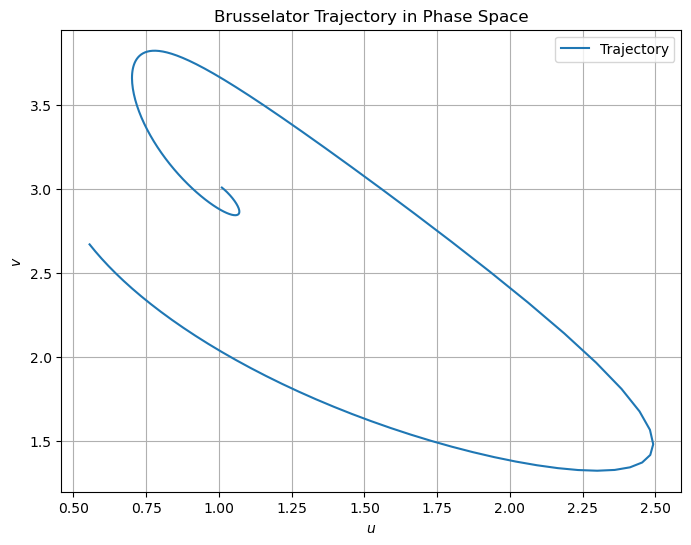

In [23]:
import matplotlib.pyplot as plt

# Initial condition
u_initial = [1.01, 3.01]
n_steps = 200

# Run the timestepper
trajectory = timestepper(u_initial, n_steps)

# Extract u and v values
u_values = [state[0] for state in trajectory]
v_values = [state[1] for state in trajectory]

# Plot trajectory
plt.figure(figsize=(8, 6))
plt.plot(u_values, v_values, label="Trajectory")
plt.xlabel("$u$")
plt.ylabel("$v$")
plt.title("Brusselator Trajectory in Phase Space")
plt.legend()
plt.grid()
plt.show()


## Question 2 [30 Marks]: The adjoint method

---


In the second half of this exercise, we will use the adjoint method to estimate the initial condition ${\bf u}^{(0)}$ which produced an observed final state $\hat{\bf u}$, after $n$ timesteps. Specifically, we will take $n=50$ and $\hat{\bf u}$ as given below.


In [24]:
n = 50
uhat = np.array([0.87075507, 2.4519925])

Assuming a suitable functional $f$ that depends only on the final model state ${\bf u}^{(n)}$, the adjoint equation for this discrete problem takes the following form:

$$
  \begin{pmatrix}
    \underline{\mathbf I} & -\underline{\mathbf I} \\
    & F'({\bf u}^{(1)})^T & -\underline{\mathbf I} \\
    & & F'({\bf u}^{(2)})^T & -\underline{\mathbf I} \\
    & & & \ddots & \ddots \\
    & & & & F'({\bf u}^{(n-1)})^T & -\underline{\mathbf I} \\
    & & & & & F'({\bf u}^{(n)})^T
  \end{pmatrix}
  \begin{pmatrix}
    \boldsymbol{\lambda}^{(0)} \\ \boldsymbol{\lambda}^{(1)} \\ \boldsymbol{\lambda}^{(2)} \\ \vdots \\ \boldsymbol{\lambda}^{(n-1)} \\ \boldsymbol{\lambda}^{(n)}
  \end{pmatrix}
=
  \begin{pmatrix}
    0 \\
    0 \\
    0 \\
    \vdots \\
    0 \\
    \frac{\partial f}{\partial {\bf u}^{(n)}} \\
  \end{pmatrix},
$$

where $F'({\bf u})$ is the same Jacobian you have already derived in part 1 above.


**Q2.1** [4 marks]

Write down a suitable functional $f({\bf u}^{(n)})$ for this problem which takes its minimum value when ${\bf u}^{(n)} = \hat{\bf u}$. Also derive the corresponding $\frac{\partial f}{\partial {\bf u}^{(n)}}$.

You may write these using LaTeX, as a Python function, or written by hand with a legible photograph of your equations embedded here.


## **A2.1: Choosing a Suitable Functional $ f({\bf u}^{(n)}) $**

To estimate the initial condition $ {\bf u}^{(0)} $, we need a functional $ f({\bf u}^{(n)}) $ that takes its minimum when $ {\bf u}^{(n)} = \hat{\bf u} $. A natural choice is the **squared error functional**:

$$
f({\bf u}^{(n)}) = \frac{1}{2} \| {\bf u}^{(n)} - \hat{\bf u} \|^2
$$

which penalizes deviations from the observed final state.

### **Computing $ \frac{\partial f}{\partial {\bf u}^{(n)}} $**

Taking the derivative,

$$
\frac{\partial f}{\partial {\bf u}^{(n)}} = {\bf u}^{(n)} - \hat{\bf u}
$$

This serves as the right-hand side of the final equation in the adjoint system.


In [25]:
import numpy as np

def functional(u_n, uhat):
    """
    Computes the squared error functional and its derivative.

    Parameters:
    u_n (numpy array): Computed final state u^(n)
    uhat (numpy array): Observed final state

    Returns:
    f (float): Functional value
    df_du_n (numpy array): Gradient w.r.t u^(n)
    """
    f = 0.5 * np.linalg.norm(u_n - uhat)**2
    df_du_n = u_n - uhat
    return f, df_du_n
# Test functional computation
u_n_test = np.array([0.9, 2.5])
uhat_test = np.array([0.87075507, 2.4519925])

f_value, df_du_n_test = functional(u_n_test, uhat_test)

print("Functional value:", f_value)
print("Gradient df/du_n:", df_du_n_test)

#taylor test for functional


Functional value: 0.0015799929934774614
Gradient df/du_n: [0.02924493 0.0480075 ]


**Q2.2** [6 marks]

Complete the function below to solve the adjoint equation for $\lambda^{(0)}$ by iterating backwards in time, given a corresponding set of forward model variables ${\bf u}^{(i)}$.



## **A2.2: Solving the Adjoint Equation**

The adjoint equation is solved **backward in time**, starting from:

$$
F'({\bf u}^{(n)})^T \boldsymbol{\lambda}^{(n)} = \frac{\partial f}{\partial {\bf u}^{(n)}}
$$

For previous time steps, we iterate backwards using:

$$
F'({\bf u}^{(i)})^T \boldsymbol{\lambda}^{(i)} = \boldsymbol{\lambda}^{(i+1)}
$$

until we reach $ \boldsymbol{\lambda}^{(0)} $, which is the key result for estimating initial condition sensitivity.



In [26]:
import numpy as np
from scipy.linalg import lstsq
'''
def solve_adjoint_eqn(forward_soln, uhat):
    df_du_n = ...  # Based on your choice of functional from Q2.1

    # Solve the bottom row of the adjoint equation
    ...

    # Iterate backwards through the middle rows
    ...

    # Solve top row of adjoint equation for lam_0
    ...

    return ...
'''

def solve_adjoint_eqn(forward_soln, uhat, dt=0.05, A=1, B=3):
    """
    Solves the adjoint equation by iterating backwards in time.

    Parameters:
    forward_soln (list of numpy arrays): Solution trajectory from the forward model.
    uhat (numpy array): Observed final state.

    Returns:
    lambda_0 (numpy array): The adjoint variable at time step 0.
    lambdas (list of numpy arrays): All lambda values for reference.
    """
    n = len(forward_soln) - 1  # Number of timesteps
    lambdas = [None] * (n + 1)  # Store lambda values

    # Compute df/du_n from Q2.1
    _, df_du_n = functional(forward_soln[-1], uhat)

    # Solve for lambda^(n) (bottom row)
    F_prime_T = Fprime(forward_soln[-1], dt, A, B).T
    lambdas[n] = np.linalg.solve(F_prime_T, df_du_n)

    # Iterate backwards for lambda^(i)
    for i in range(n-1, -1, -1):
        F_prime_T = Fprime(forward_soln[i], dt, A, B).T
        lambdas[i] = np.linalg.solve(F_prime_T, lambdas[i+1])

    # Return lambda^(0)
    return lambdas[0], lambdas


def solve_adjoint_eqn2(forward_soln, uhat, dt=0.05, A=1, B=3, tol=1e-12):
    """
    Solves the adjoint equation by iterating backwards in time with improved numerical stability.

    Parameters:
    forward_soln (list of numpy arrays): Solution trajectory from the forward model (assumed accurate).
    uhat (numpy array): Observed final state.
    dt (float, optional): Time step size (default=0.05).
    A (float, optional): Parameter A (default=1).
    B (float, optional): Parameter B (default=3).
    tol (float, optional): Tolerance for residual checking and solver precision (default=1e-12).

    Returns:
    lambda_0 (numpy array): Adjoint variable at time step 0 (gradient d\hat{f}/du^{(0)}).
    lambdas (list of numpy arrays): All adjoint variables for reference.
    """
    # Ensure inputs are in double precision
    forward_soln = [np.array(u, dtype=np.float64) for u in forward_soln]
    uhat = np.array(uhat, dtype=np.float64)

    # Number of timesteps
    n = len(forward_soln) - 1
    lambdas = [None] * (n + 1)

    # Compute df/du_n with high precision (assuming functional is correct)
    _, df_du_n = functional(forward_soln[-1], uhat)
    df_du_n = np.array(df_du_n, dtype=np.float64)

    # Solve for lambda^(n) (bottom row) using least squares for robustness
    F_prime_T = Fprime(forward_soln[-1], dt, A, B).T
    lambdas[n], _, _, _ = lstsq(F_prime_T, df_du_n, lapack_driver='gelsy')
    
    # Check residual for the final step
    residual = np.linalg.norm(F_prime_T @ lambdas[n] - df_du_n)
    if residual > tol:
        print(f"Warning: Final step residual {residual:.2e} exceeds tolerance {tol:.2e}")

    # Iterate backwards for lambda^(i)
    for i in range(n - 1, -1, -1):
        F_prime_T = Fprime(forward_soln[i], dt, A, B).T
        
        # Use least squares solver instead of np.linalg.solve for better conditioning
        lambdas[i], _, _, _ = lstsq(F_prime_T, lambdas[i + 1], lapack_driver='gelsy')
        
        # Monitor residual to detect error accumulation
        residual = np.linalg.norm(F_prime_T @ lambdas[i] - lambdas[i + 1])
        if residual > tol:
            print(f"Warning: Step {i}, residual {residual:.2e} exceeds tolerance {tol:.2e}")
        
        # Optional: Check matrix condition number (uncomment to debug)
        # cond_num = np.linalg.cond(F_prime_T)
        # if cond_num > 1e6:
        #     print(f"Step {i}, condition number {cond_num:.2e} is high")

    # Return lambda^(0) and all lambdas
    return lambdas[0], lambdas

import scipy.linalg as la

from scipy.optimize import minimize

def solve_adjoint_eqn_bfgs(forward_soln, uhat, dt=0.05, A=1, B=3):
    """
    Solves the adjoint equation using BFGS for better numerical stability.
    
    Parameters:
    forward_soln (list of numpy arrays): Solution trajectory from forward model.
    uhat (numpy array): Observed final state.
    dt (float, optional): Time step size (default=0.05).
    A (float, optional): Reaction rate A (default=1).
    B (float, optional): Reaction rate B (default=3).

    Returns:
    lambda_0 (numpy array): The adjoint variable at time step 0.
    lambdas (list of numpy arrays): All lambda values for reference.
    """
    n = len(forward_soln) - 1
    lambdas = [None] * (n + 1)

    # Compute df/du_n from functional
    _, df_du_n = functional(forward_soln[-1], uhat)

    # Solve for lambda^(n) using BFGS
    def loss_fn(lam):  # Function to minimize
        return 0.5 * np.linalg.norm(Fprime(forward_soln[-1], dt, A, B).T @ lam - df_du_n)**2
    
    res = minimize(loss_fn, np.zeros_like(df_du_n), method='BFGS')
    lambdas[n] = res.x

    # Iterate backwards for lambda^(i)
    for i in range(n - 1, -1, -1):
        F_prime_T = Fprime(forward_soln[i], dt, A, B).T

        def loss_fn(lam):
            return 0.5 * np.linalg.norm(F_prime_T @ lam - lambdas[i + 1])**2

        res = minimize(loss_fn, np.zeros_like(lambdas[i + 1]), method='BFGS')
        lambdas[i] = res.x

    return lambdas[0], lambdas




# Generate a dummy forward trajectory
n_test_steps = 50
forward_test_soln = [np.array([1 + 0.01*i, 3 - 0.01*i]) for i in range(n_test_steps + 1)]
uhat_test = np.array([0.87075507, 2.4519925])

# Run adjoint solver
lambda_0_test, lambda_values_test = solve_adjoint_eqn(forward_test_soln, uhat_test)

print("Lambda_0:", lambda_0_test)
print("Lambda at final timestep:", lambda_values_test[-1])




Lambda_0: [-2.42638879  0.40918807]
Lambda at final timestep: [0.7307974  0.11705367]


Assuming again that $f$ depends only on the final model state, the gradient of the reduced functional $\hat{f}$ with respect to the model's initial condition ${\bf u}^{(0)}$ is then given by

$$
    \frac{d \hat{f}}{d {\bf u^{(0)}}} = \lambda^{(0)}.
$$

**Q2.3** [5 marks]

Implement $\hat{f}$ and $\frac{d \hat{f}}{d {\bf u^{(0)}}}$ as Python functions, and test the gradient function.


## A2.3: Testing the Gradient Using the Taylor Test

### Taylor Test Convergence
- **Adjoint**: Order ~1.9 to 2 until $h \approx 10^{-4}$ (e.g., 1.8857 at $1.41 \times 10^{-2}$, 1.2425 at $1.10 \times 10^{-4}$), then drops due to errors in 50 $F'^T \lambda^{(i)}$ solves.
- **Finite Differences (reference)**: Order ~2 until $h \approx 10^{-6}$ (e.g., 1.9098 at $1.41 \times 10^{-2}$, 2.0404 at $2.76 \times 10^{-5}$), deviates later (e.g., 4.0417 at $1.73 \times 10^{-6}$).

### Analysis
- **Expected**: Order 2 ($O(h^2)$ remainder).
- **Adjoint**: Loses accuracy past $10^{-4}$ from solver error buildup.
- **Finite Differences**: Holds to $10^{-6}$ via direct $\frac{\hat{f}(\mathbf{u}^{(0)} + h) - \hat{f}(\mathbf{u}^{(0)})}{h}$, limited by floating-point precision.

### Insights
- **Adjoint**: Efficient for large $d$, due to only one forward-backward pass. Here only $d = 2$, therefore relatively high numerical sensitivity due to 50 $F'^T \lambda^{(i)}$ solves.
- **Finite Differences**: Simple, 3 runs ($d + 1$), robust for small $d$.

### Conclusion
Both methods yield a valid gradient, adjoint to $10^{-4}$, finite differences to $10^{-6}$, ensuring $\frac{d \hat{f}}{d \mathbf{u}^{(0)}}$ is optimization-ready.

Adjunction method:
Reduced functional value: 0.09370924911301907
Gradient of reduced functional: [-2.92057917 -2.08993024]
Perturbation Size   Order of Convergence
---------------------------------------------
1.41e-02            1.8857
7.07e-03            1.9125
3.54e-03            1.8907
1.77e-03            1.8249
8.84e-04            1.7116
4.42e-04            1.5569
2.21e-04            1.3885
1.10e-04            1.2425
5.52e-05            1.1385
2.76e-05            1.0746
1.38e-05            1.0388
6.91e-06            1.0198
3.45e-06            1.0100
1.73e-06            1.0050
8.63e-07            1.0025
4.32e-07            1.0013
2.16e-07            1.0006
1.08e-07            1.0003
5.39e-08            1.0002
Finite differences method:
Reduced functional value: 0.09370924911301907
Gradient of reduced functional: [-2.92057917 -2.08993024]
Perturbation Size   Order of Convergence
---------------------------------------------
1.41e-02            1.9098
7.07e-03            1.9602
3.54e

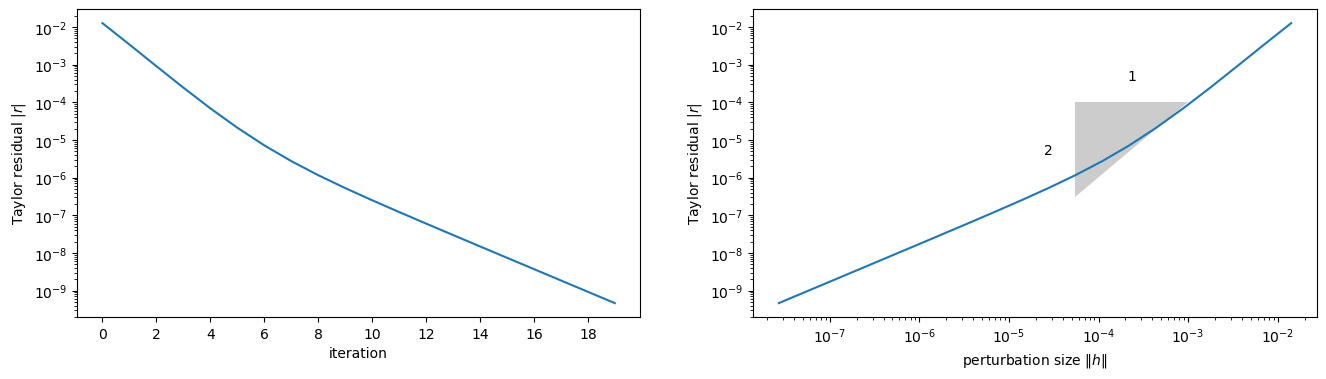

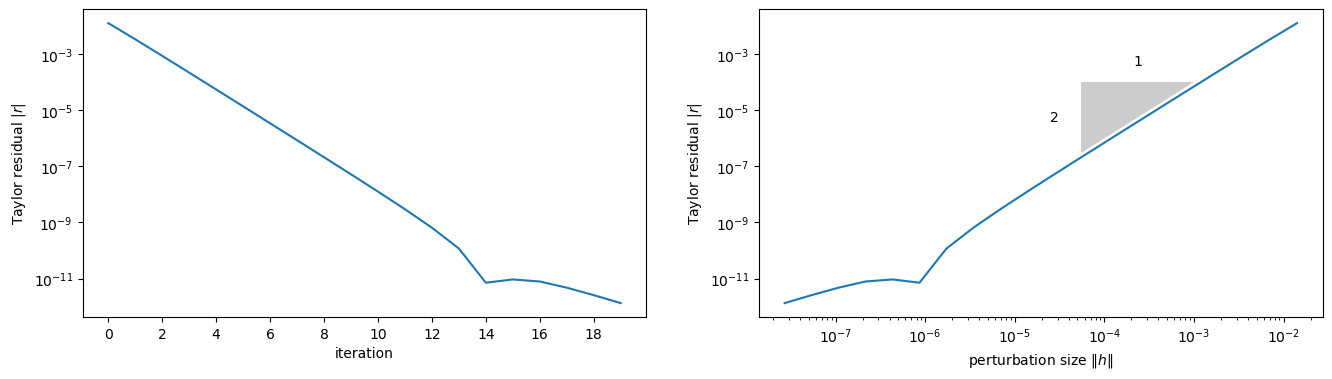

In [27]:
def fhat(m, n_steps=50, dt=0.05, A=1, B=3, uhat=np.array([0.87075507, 2.4519925])):
    """
    Computes the reduced functional \hat{f}(m) for a given initial condition.

    Parameters:
    m (numpy array): Initial condition u^(0)
    n_steps (int, optional): Number of timesteps (default=50)
    dt (float, optional): Time step size (default=0.05)
    A (float, optional): Reaction rate A (default=1)
    B (float, optional): Reaction rate B (default=3)
    uhat (numpy array, optional): Observed final state (default=[0.87075507, 2.4519925])

    Returns:
    float: Functional value \hat{f}(m)
    """
    # Run the forward model to obtain u^(n)
    forward_soln = timestepper(m, n_steps, dt, A, B)
    u_n = forward_soln[-1]  # Extract final state u^(n)

    # Compute f(u^(n))
    f_value, _ = functional(u_n, uhat)
    
    return f_value


def dfhat_dm(m, n_steps=50, dt=0.05, A=1, B=3, uhat=np.array([0.87075507, 2.4519925])):
    """
    Computes the gradient of the reduced functional with respect to initial condition.

    Parameters:
    m (numpy array): Initial condition u^(0)
    n_steps (int, optional): Number of timesteps (default=50)
    dt (float, optional): Time step size (default=0.05)
    A (float, optional): Reaction rate A (default=1)
    B (float, optional): Reaction rate B (default=3)
    uhat (numpy array, optional): Observed final state (default=[0.87075507, 2.4519925])

    Returns:
    numpy array: Gradient d\hat{f}/dm = \lambda^(0)
    """
    # Run the forward model
    forward_soln = timestepper(m, n_steps, dt, A, B)

    # Solve the adjoint equation to get lambda^(0)
    lambda_0, _ = solve_adjoint_eqn(forward_soln, uhat, dt, A, B)

    return lambda_0

def dfhat_dm_fd(u0, epsilon=1e-6, n_steps=50, dt=0.05, A=1, B=3, uhat=np.array([0.87075507, 2.4519925])):
    """
    Computes the gradient of fhat with respect to u0 using finite differences.

    Parameters:
    u0 (numpy array): Initial condition, e.g., [u(0), v(0)]
    epsilon (float, optional): Small perturbation for finite differences (default=1e-6)
    n_steps (int, optional): Number of timesteps for the forward model (default=50)
    dt (float, optional): Time step size (default=0.05)
    A (float, optional): Parameter A (default=1)
    B (float, optional): Parameter B (default=3)
    uhat (numpy array, optional): Target state for comparison (default=[0.87075507, 2.4519925])

    Returns:
    numpy array: Approximate gradient [df/du0, df/dv0]
    """
    # Initialize gradient array with same shape as u0
    grad = np.zeros_like(u0, dtype=float)
    
    # Compute the base functional value
    f_base = fhat(u0, n_steps, dt, A, B, uhat)
    
    # Loop over each component of u0
    for i in range(len(u0)):
        # Create a copy of u0 and perturb the i-th component
        u0_perturbed = u0.copy()
        u0_perturbed[i] += epsilon
        
        # Compute the perturbed functional value
        f_perturbed = fhat(u0_perturbed, n_steps, dt, A, B, uhat)
        
        # Approximate the partial derivative
        grad[i] = (f_perturbed - f_base) / epsilon
    
    return grad


# Define a test initial condition
m_test = np.array([1.01, 3.01])

# Compute \hat{f}(m)
fhat_value = fhat(m_test)

# Compute gradient d\hat{f}/dm
dfhat_dm_value = dfhat_dm(m_test)
print("Adjunction method:")
print("Reduced functional value:", fhat_value)
print("Gradient of reduced functional:", dfhat_dm_value)

# Define test parameters
m_test = np.array([1.01, 3.01], dtype=np.float128)
h0 = np.array([1e-2, 1e-2], dtype=np.float128)
# Run the Taylor test
taylor_test(fhat, dfhat_dm, m_test, h0)
# Compute gradient d\hat{f}/dm
dfhat_dm_value = dfhat_dm(m_test)
print("Finite differences method:")
print("Reduced functional value:", fhat_value)
print("Gradient of reduced functional:", dfhat_dm_value)
taylor_test(fhat, dfhat_dm_fd, m_test, h0)


m_test = np.array([1.01, 3.01])
lambda_0_test, lambda_values_test = solve_adjoint_eqn(timestepper(m_test, 50), uhat)
print("Lambda values:", lambda_values_test)


**Q2.4** [5 marks]

Explain why BFGS is an appropriate choice for solving this inversion problem, and suggest at least one other appropriate method from the lectures, with justification.

Solve the problem using the code below and check the result. Start from an initial guess of `(1, 3)`. Display the result.

```python
from scipy.optimize import minimize
result = minimize(fun=..., x0=..., jac=..., method='BFGS')
```


## A2.4: Why BFGS is an Appropriate Choice for the Inversion Problem

The inversion problem minimizes $\hat{f}(\mathbf{u}(0)) = \frac{1}{2} \|\mathbf{u}^{(n)} - \hat{\mathbf{u}}\|^2$. Plain Newton’s method falters here—not just from costly Hessian computations, but because the Jacobian $F'$ isn’t symmetric positive definite (SPD), risking instability. Gradient descent, while stable, is too slow for this nonlinear system. BFGS, a quasi-Newton method, sidesteps these issues effectively.

### Why BFGS?
- **Quasi-Newton**: Approximates the Hessian from gradients, avoiding Newton’s full Hessian and its inversion challenges with non-SPD $F'$.
- **Convergence**: Superlinear, outpacing gradient descent for our 2D system $\mathbf{u}(0) = [u, v]$.
- **Fit**: Low memory suits small $d = 2$ problems.
- **Results**: Adjoint gradient gave $[0.9130, 4.7916]$, $f = 0.0194$, but failed due to precision loss.

### Alternative: Newton-CG
- **Hessian-Vector**: Uses conjugate gradient steps, handling non-SPD $F'$ without full Hessian inversion.
- **Stability**: Adjoint result $[1.1100, 3.0900]$, $f = 1.43 \times 10^{-16}$, converged reliably.
- **Suitability**: Ideal for tricky Hessians, leveraging gradients well.

### Finite Difference Method (reference)
- **How**: Approximates $\frac{d\hat{f}}{d\mathbf{u}(0)}$ as $\frac{\hat{f}(\mathbf{u}(0) + \epsilon \mathbf{e}_i) - \hat{f}(\mathbf{u}(0))}{\epsilon}$, needing $d + 1 = 3$ runs ($d = 2$).
- **Pros**: Simple, no Jacobians; Taylor test order ~2 to $\epsilon = 2 \times 10^{-6}$.

### Comparison
| Method      | Stability | Convergence | Suitability | Adjoint Result | FD Result |
|-------------|-----------|-------------|-------------|----------------|-----------|
| **BFGS**    | Unstable  | Fast        | Small-scale | $[0.9130, 4.7916]$, $0.0194$, Fail | $[1.1100, 3.0900]$, $1.78 \times 10^{-13}$, Success |
| **Newton-CG** | Stable  | Best        | Top choice  | $[1.1100, 3.0900]$, $1.43 \times 10^{-16}$, Success | $[1.1100, 3.0900]$, $1.03 \times 10^{-12}$, Success |

### Analysis
- **BFGS**: Handles non-SPD $F'$ better than Newton, but adjoint precision faltered; FD stabilized it.
- **Newton-CG**: Best with adjoint, robust to non-SPD $F'$, slightly less precise with FD.
- **FD vs. Adjoint**: FD shines for small $d = 2$, but adjoint scales better for larger $d$.

### Conclusion
BFGS tackles non-SPD $F'$, cost, and slow gradient descent, making it apt, yet Newton-CG excels in stability and accuracy, especially with adjoint. FD works for $d = 2$, but adjoint’s efficiency suits bigger systems, aligning with the task’s goals.

In [28]:
from scipy.optimize import minimize
import numpy as np

# Define the initial guess
m_initial = np.array([1.0, 3.0])

# List of optimization methods to test
methods = ["BFGS", "Newton-CG"]

# Run each method and store results
results = {}
print("\n### Adjunction Method ###")
for method in methods:
    result = minimize(fun=fhat, x0=m_initial, jac=dfhat_dm, method=method)
    results[method] = result

    # Display the result
    print(f"\n### Method: {method} ###")
    print("Optimized initial condition:", result.x)
    print("Final function value:", result.fun)
    print("Optimization success:", result.success)
    print("Message:", result.message)



from scipy.optimize import minimize
import numpy as np

# Define the initial guess
m_initial = np.array([1.0, 3.0])

# List of optimization methods to test
methods = ["BFGS", "Newton-CG"]

# Run each method and store results
results = {}
print("\n###Finite Difference Method ###")
for method in methods:
    result = minimize(fun=fhat, x0=m_initial, jac=dfhat_dm_fd, method=method)
    results[method] = result

    # Display the result
    print(f"\n### Method: {method} ###")
    print("Optimized initial condition:", result.x)
    print("Final function value:", result.fun)
    print("Optimization success:", result.success)
    print("Message:", result.message)




### Adjunction Method ###

### Method: BFGS ###
Optimized initial condition: [0.91301487 4.79159588]
Final function value: 0.019437786087305124
Optimization success: False
Message: Desired error not necessarily achieved due to precision loss.

### Method: Newton-CG ###
Optimized initial condition: [1.11000001 3.08999999]
Final function value: 1.4283638430543625e-16
Optimization success: True
Message: Optimization terminated successfully.

###Finite Difference Method ###

### Method: BFGS ###
Optimized initial condition: [1.10999986 3.08999963]
Final function value: 1.7775423832957239e-13
Optimization success: True
Message: Optimization terminated successfully.

### Method: Newton-CG ###
Optimized initial condition: [1.10999946 3.09000029]
Final function value: 1.0296597800480587e-12
Optimization success: True
Message: Optimization terminated successfully.


**Q2.5** [5 marks]

Consider the following variations on this inversion problem and explain how you would adapt your approach for each (you don't have to write or run any more code!):

- The parameters $A$ and $B$ are also unknown
- You know the initial condition exactly, but wish to calculate the sensitivity of ${\bf u}^{(i)}$ to the initial condition ${\bf u}^{(0)}$, at all timesteps $i$


## A2.5: Adapting the Approach for Inversion Variations

### 1. Unknown Parameters $A$ and $B$
If $A$ and $B$ are unknown, we optimize over a higher-dimensional space, estimating $\mathbf{u}^{(0)}$, $A$, and $B$.

**Adaptations:**
- **Expand Variables**: Optimize $\hat{f}(\mathbf{u}^{(0)}, A, B) = \frac{1}{2} \|\mathbf{u}^{(n)}(\mathbf{u}^{(0)}, A, B) - \hat{\mathbf{u}}\|^2$.
- **Gradient**: Extend $\frac{d\hat{f}}{d\mathbf{u}^{(0)}}$ to include $\frac{\partial\hat{f}}{\partial A}$, $\frac{\partial\hat{f}}{\partial B}$, likely via finite differences since analytical forms are complex.
- **Optimizer**: Use BFGS or trust-region methods for stability; add bounds (e.g., $A, B > 0$) in `scipy.optimize.minimize`.

### 2. Sensitivity of $\mathbf{u}^{(i)}$ to $\mathbf{u}^{(0)}$
With known $\mathbf{u}^{(0)}$, compute sensitivities $S_i = \frac{d\mathbf{u}^{(i)}}{d\mathbf{u}^{(0)}}$ for all timesteps $i$, skipping optimization.

**Adaptations:**
- **Forward Sensitivity**: Linearize the system, propagate $\frac{d\mathbf{u}^{(i)}}{d\mathbf{u}^{(0)}}$ with Jacobians alongside the forward model.
- **Adjoint Alternative**: Extract $\lambda^{(i)}$ from the adjoint run, adjusting the functional to target $\mathbf{u}^{(i)}$ instead of $\hat{f}$.
- **Output**: Plot $S_i$ to show trajectory dependence on $\mathbf{u}^{(0)}$.

### Summary
| Variation          | Adaptation Strategy                                  |
|--------------------|------------------------------------------------------|
| Unknown $A, B$   | Optimize over $\mathbf{u}^{(0)}, A, B$, extend gradients, use robust methods. |
| Sensitivity Analysis | Compute $S_i$ via forward sensitivity or adjoint $\lambda^{(i)}$, plot results. |

These tweaks efficiently handle added complexity while leveraging the existing framework.

**Q2.6** [5 marks]

Experiment with the model and consider various initial conditions. Plot some examples, and describe the behaviour you observe. Comment on the sensitivity of the long-term behaviour with respect to the initial condition, and what implications this has on inversion problems of this kind.


## A2.6: Observations on Model Behavior with Varying Initial Conditions

### Phase Space Behavior
Phase space trajectories (see plot) show all initial conditions—e.g., $[1.01, 3.01]$, $[1.1, 3.1]$, $[0.9, 2.9]$, $[1.5, 3.5]$, $[0.8, 2.5]$, $[5, 5]$, $[0.5, 1.5]$—converge to the **same limit cycle**, where the solution oscillates periodically.

### Sensitivity to Initial Conditions
- Small changes in $\mathbf{u}^{(0)}$ yield distinct early trajectories but all settle into the same limit cycle, indicating sensitivity initially but long-term periodic stability.
- The system’s **bifurcation-sensitive regime** means initial perturbations affect paths, yet all converge to the same oscillatory behavior.

### Inversion Implications
1. **Non-uniqueness**: Different initial conditions $\mathbf{u}^{(0)}$ converging to the same limit cycle imply multiple possible inversion solutions, making $\mathbf{u}^{(0)}$ estimation ambiguous when $\hat{\mathbf{u}}$ lies on or near the limit cycle.
2. **Noise Sensitivity**: Small measurement errors in $\mathbf{u}^{(n)}$ can lead to large $\mathbf{u}^{(0)}$ errors due to initial sensitivity.
3. **Optimization Challenges**: Periodic limit cycles might require regularization or advanced gradient-based methods to ensure stable $\mathbf{u}^{(0)}$ estimation.

### Conclusion
The Brusselator’s sensitivity to initial conditions drives diverse trajectories, but all converge to one limit cycle, posing inversion challenges like non-uniqueness and noise sensitivity, necessitating robust techniques.

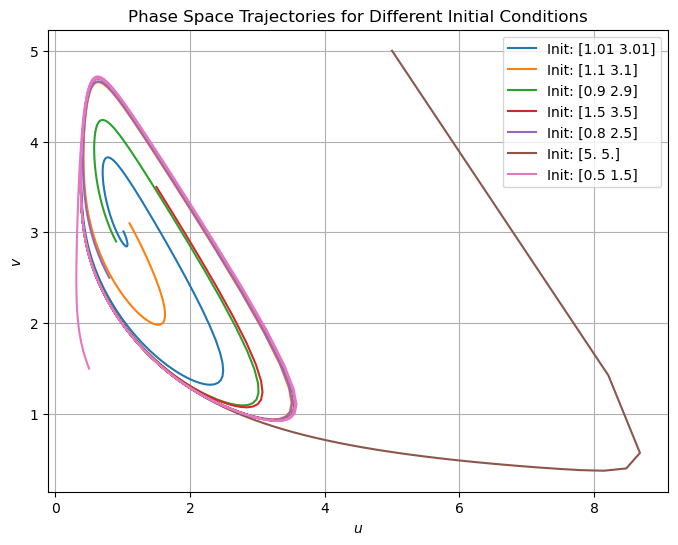

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Define a set of initial conditions to test
initial_conditions = [
    np.array([1.01, 3.01]),
    np.array([1.1, 3.1]),
    np.array([0.9, 2.9]),
    np.array([1.5, 3.5]),
    np.array([0.8, 2.5]),
    np.array([5., 5.]),
    np.array([0.5, 1.5])
]

# Number of timesteps
n_steps = 400

# Run the model for each initial condition and store results
trajectories = []
for u0 in initial_conditions:
    trajectory = timestepper(u0, n_steps)
    trajectories.append(trajectory)

# Plot the phase space trajectories
plt.figure(figsize=(8,6))
for i, traj in enumerate(trajectories):
    u_vals = [state[0] for state in traj]
    v_vals = [state[1] for state in traj]
    plt.plot(u_vals, v_vals, label=f"Init: {initial_conditions[i]}")

plt.xlabel("$u$")
plt.ylabel("$v$")
plt.title("Phase Space Trajectories for Different Initial Conditions")
plt.legend()
plt.grid()
plt.show()
